Index -> WindowSize mapping:
  idx  1 -> ws  10   (P samples: 5, R samples: 5)
  idx  2 -> ws  15   (P samples: 5, R samples: 5)
  idx  3 -> ws  20   (P samples: 5, R samples: 5)
  idx  4 -> ws  25   (P samples: 5, R samples: 5)
  idx  5 -> ws  30   (P samples: 5, R samples: 5)
  idx  6 -> ws  35   (P samples: 5, R samples: 5)
  idx  7 -> ws  40   (P samples: 5, R samples: 5)
  idx  8 -> ws  45   (P samples: 5, R samples: 5)
  idx  9 -> ws  50   (P samples: 5, R samples: 5)
  idx 10 -> ws  55   (P samples: 4, R samples: 4)
  idx 11 -> ws  60   (P samples: 4, R samples: 4)
  idx 12 -> ws  65   (P samples: 4, R samples: 4)
  idx 13 -> ws  70   (P samples: 4, R samples: 4)
  idx 14 -> ws  75   (P samples: 4, R samples: 4)
  idx 15 -> ws  80   (P samples: 4, R samples: 4)
Plot saved to: plots\precision_recall_ws_sx.png


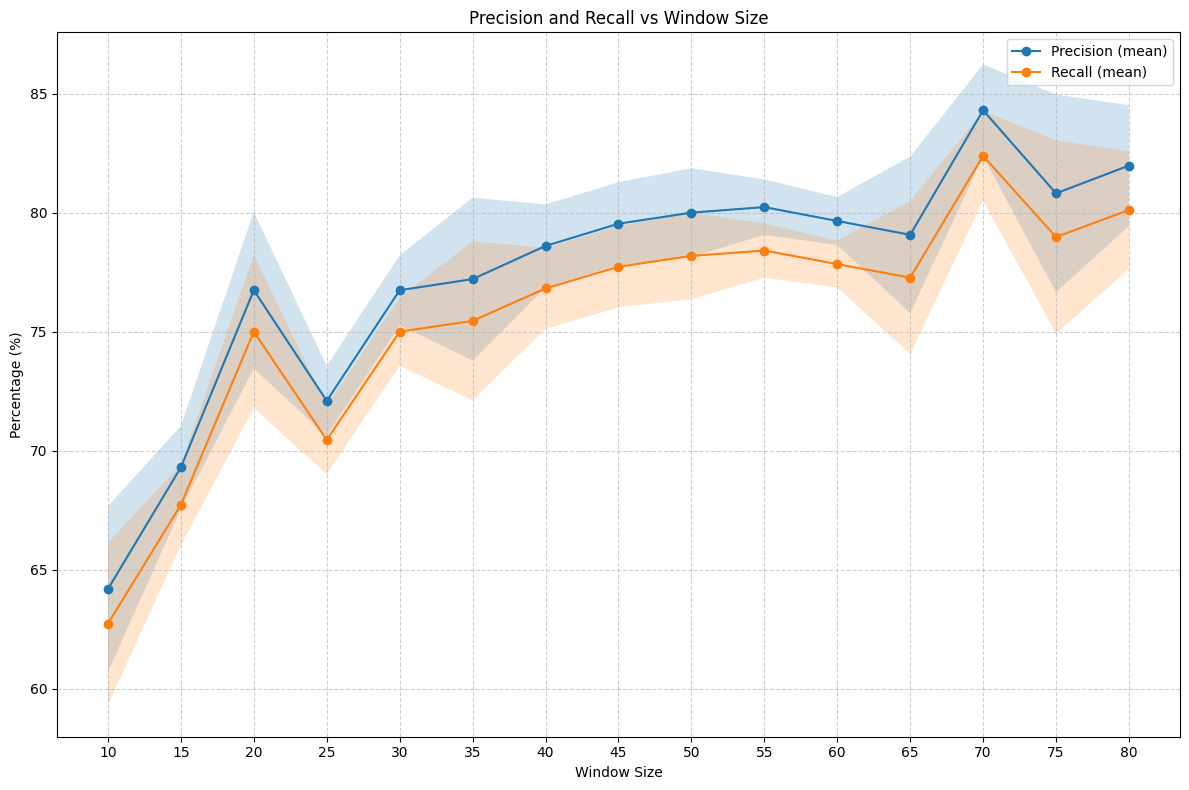

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# === Config ===
PARENT_FOLDER = 'evaluations/ws_s10'  # root folder containing numbered subfolders: 1/, 2/, ...
OUTPUT_FOLDER = 'plots'
START_WS = 10   # window size for index 1
STEP_WS = 5     # increment per index step

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

def extract_metrics(file_path):
    """Extract Precision and Recall from a results .txt file."""
    precision, recall = None, None
    with open(file_path, 'r') as f:
        for line in f:
            if "Precision" in line:
                precision = float(line.strip().split(":")[-1].replace('%', '').strip())
            elif "Recall" in line:
                recall = float(line.strip().split(":")[-1].replace('%', '').strip())
    return precision, recall

def extract_index(filename):
    """
    Extract the LAST integer before .txt to serve as the per-run index (1,2,3,...).
    Works for names like results_1.txt, out1.txt, foo_bar_12.txt, etc.
    """
    m = re.search(r'(\d+)(?=\.txt$)', filename)
    return int(m.group(1)) if m else None

def get_stride_from_folder(folder):
    """Extract stride from folder name, e.g. 'ws_s10' -> 10. Returns None if not found."""
    m = re.search(r's(\d+)', os.path.basename(folder))
    return int(m.group(1)) if m else None

def plot_metrics():
    stride = get_stride_from_folder(PARENT_FOLDER)

    # Collect numbered subfolders (1/, 2/, ...)
    run_folders = [
        os.path.join(PARENT_FOLDER, d)
        for d in os.listdir(PARENT_FOLDER)
        if os.path.isdir(os.path.join(PARENT_FOLDER, d)) and d.isdigit()
    ]
    run_folders.sort(key=lambda p: int(os.path.basename(p)))  # sort by run number

    # Aggregate by per-run file index (1,2,3,...) so y-values stay identical;
    # we will only relabel the x-axis later to window sizes.
    precisions_by_idx = {}
    recalls_by_idx = {}

    for run_folder in run_folders:
        # Collect .txt files, keep only those with a numeric index, sort by that index
        files = [f for f in os.listdir(run_folder) if f.endswith('.txt')]
        files_with_idx = [(f, extract_index(f)) for f in files]
        files_with_idx = [(f, idx) for f, idx in files_with_idx if idx is not None]
        files_with_idx.sort(key=lambda t: t[1])  # sort by index

        for filename, idx in files_with_idx:
            file_path = os.path.join(run_folder, filename)
            precision, recall = extract_metrics(file_path)
            if precision is None or recall is None:
                continue
            precisions_by_idx.setdefault(idx, []).append(precision)
            recalls_by_idx.setdefault(idx, []).append(recall)

    # Align indices that appear in either metric (use intersection to ensure both exist)
    common_indices = sorted(set(precisions_by_idx.keys()) & set(recalls_by_idx.keys()))
    if not common_indices:
        print("No common indices found across runs with both Precision and Recall.")
        return

    # Compute means & stds per index
    mean_precisions = [np.mean(precisions_by_idx[i]) for i in common_indices]
    std_precisions  = [np.std(precisions_by_idx[i])  for i in common_indices]

    mean_recalls = [np.mean(recalls_by_idx[i]) for i in common_indices]
    std_recalls  = [np.std(recalls_by_idx[i])  for i in common_indices]

    # Map index -> window size (labels only; data unchanged)
    window_sizes = [START_WS + (i - 1) * STEP_WS for i in common_indices]

    # Optional: print a small mapping check
    print("Index -> WindowSize mapping:")
    for i, ws in zip(common_indices, window_sizes):
        n_runs_p = len(precisions_by_idx[i])
        n_runs_r = len(recalls_by_idx[i])
        print(f"  idx {i:>2} -> ws {ws:>3}   (P samples: {n_runs_p}, R samples: {n_runs_r})")

    # Plot with error bands (mean ± std)
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(window_sizes, mean_precisions, label='Precision (mean)', marker='o')
    ax.fill_between(window_sizes,
                    np.array(mean_precisions) - np.array(std_precisions),
                    np.array(mean_precisions) + np.array(std_precisions),
                    alpha=0.2)

    ax.plot(window_sizes, mean_recalls, label='Recall (mean)', marker='o')
    ax.fill_between(window_sizes,
                    np.array(mean_recalls) - np.array(std_recalls),
                    np.array(mean_recalls) + np.array(std_recalls),
                    alpha=0.2)

    title = "Precision and Recall vs Window Size"
    if stride is not None:
        title += f" (Stride {stride})"
    ax.set_title(title)
    ax.set_xlabel("Window Size")
    ax.set_ylabel("Percentage (%)")
    ax.set_xticks(window_sizes)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend()

    out_path = os.path.join(OUTPUT_FOLDER, f'precision_recall_ws_s{stride or "x"}.png')
    plt.tight_layout()
    plt.savefig(out_path)
    print(f"Plot saved to: {out_path}")
    plt.show()
    plt.close(fig)

# Run
plot_metrics()                                





Index -> WindowSize mapping:
  idx  1 -> ws   5   (P samples: 5, R samples: 5)
  idx  2 -> ws  10   (P samples: 5, R samples: 5)
  idx  3 -> ws  15   (P samples: 5, R samples: 5)
  idx  4 -> ws  20   (P samples: 5, R samples: 5)
  idx  5 -> ws  25   (P samples: 5, R samples: 5)
  idx  6 -> ws  30   (P samples: 5, R samples: 5)
  idx  7 -> ws  35   (P samples: 5, R samples: 5)
  idx  8 -> ws  40   (P samples: 5, R samples: 5)
  idx  9 -> ws  45   (P samples: 5, R samples: 5)
  idx 10 -> ws  50   (P samples: 5, R samples: 5)
  idx 11 -> ws  55   (P samples: 5, R samples: 5)
  idx 12 -> ws  60   (P samples: 5, R samples: 5)
  idx 13 -> ws  65   (P samples: 5, R samples: 5)
Plot saved to: plots\precision_recall_ws_s5.png


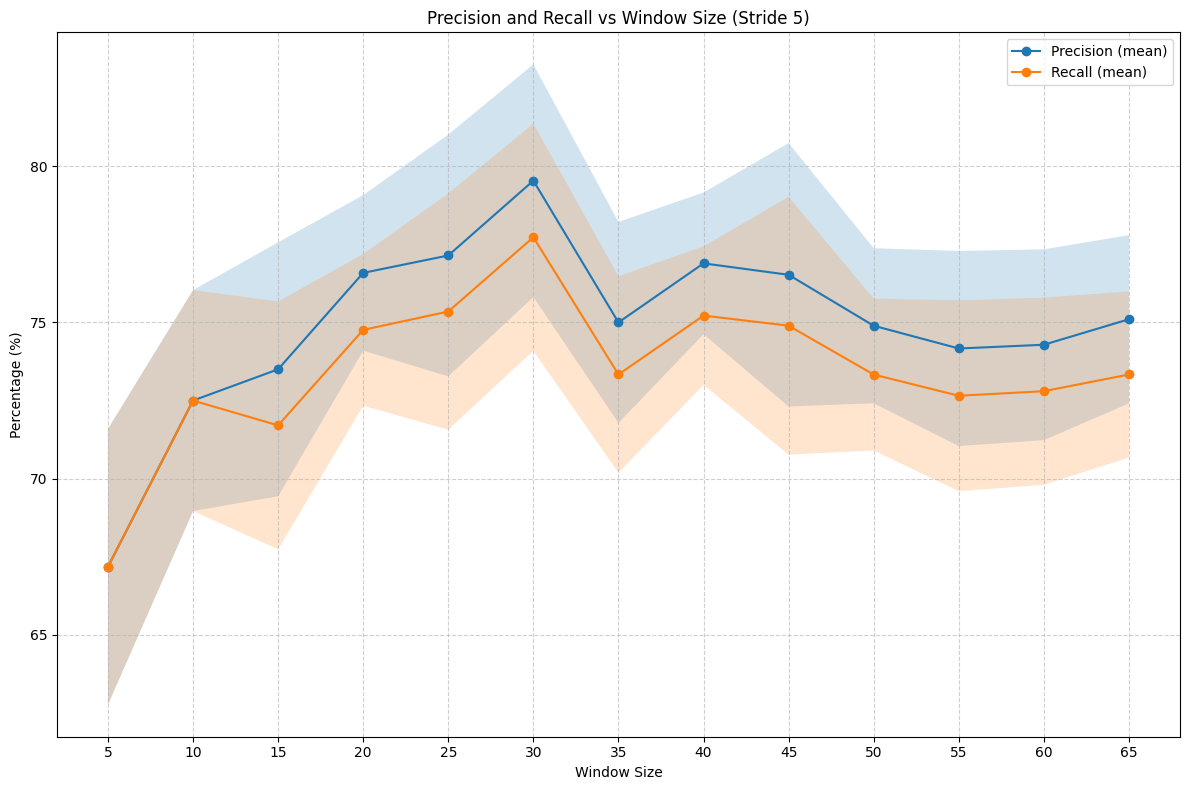

In [19]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# === Config ===
PARENT_FOLDER = 'evaluations/ws_s5'  # root folder containing numbered subfolders: 1/, 2/, ...
OUTPUT_FOLDER = 'plots'
START_WS = 5   # window size for index 1
STEP_WS = 5     # increment per index step

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

def extract_metrics(file_path):
    """Extract Precision and Recall from a results .txt file."""
    precision, recall = None, None
    with open(file_path, 'r') as f:
        for line in f:
            if "Precision" in line:
                precision = float(line.strip().split(":")[-1].replace('%', '').strip())
            elif "Recall" in line:
                recall = float(line.strip().split(":")[-1].replace('%', '').strip())
    return precision, recall

def extract_index(filename):
    """
    Extract the LAST integer before .txt to serve as the per-run index (1,2,3,...).
    Works for names like results_1.txt, out1.txt, foo_bar_12.txt, etc.
    """
    m = re.search(r'(\d+)(?=\.txt$)', filename)
    return int(m.group(1)) if m else None

def get_stride_from_folder(folder):
    """Extract stride from folder name, e.g. 'ws_s10' -> 10. Returns None if not found."""
    m = re.search(r's(\d+)', os.path.basename(folder))
    return int(m.group(1)) if m else None

def plot_metrics():
    stride = get_stride_from_folder(PARENT_FOLDER)

    # Collect numbered subfolders (1/, 2/, ...)
    run_folders = [
        os.path.join(PARENT_FOLDER, d)
        for d in os.listdir(PARENT_FOLDER)
        if os.path.isdir(os.path.join(PARENT_FOLDER, d)) and d.isdigit()
    ]
    run_folders.sort(key=lambda p: int(os.path.basename(p)))  # sort by run number

    # Aggregate by per-run file index (1,2,3,...) so y-values stay identical;
    # we will only relabel the x-axis later to window sizes.
    precisions_by_idx = {}
    recalls_by_idx = {}

    for run_folder in run_folders:
        # Collect .txt files, keep only those with a numeric index, sort by that index
        files = [f for f in os.listdir(run_folder) if f.endswith('.txt')]
        files_with_idx = [(f, extract_index(f)) for f in files]
        files_with_idx = [(f, idx) for f, idx in files_with_idx if idx is not None]
        files_with_idx.sort(key=lambda t: t[1])  # sort by index

        for filename, idx in files_with_idx:
            file_path = os.path.join(run_folder, filename)
            precision, recall = extract_metrics(file_path)
            if precision is None or recall is None:
                continue
            precisions_by_idx.setdefault(idx, []).append(precision)
            recalls_by_idx.setdefault(idx, []).append(recall)

    # Align indices that appear in either metric (use intersection to ensure both exist)
    common_indices = sorted(set(precisions_by_idx.keys()) & set(recalls_by_idx.keys()))
    if not common_indices:
        print("No common indices found across runs with both Precision and Recall.")
        return

    # Compute means & stds per index
    mean_precisions = [np.mean(precisions_by_idx[i]) for i in common_indices]
    std_precisions  = [np.std(precisions_by_idx[i])  for i in common_indices]

    mean_recalls = [np.mean(recalls_by_idx[i]) for i in common_indices]
    std_recalls  = [np.std(recalls_by_idx[i])  for i in common_indices]

    # Map index -> window size (labels only; data unchanged)
    window_sizes = [START_WS + (i - 1) * STEP_WS for i in common_indices]

    # Optional: print a small mapping check
    print("Index -> WindowSize mapping:")
    for i, ws in zip(common_indices, window_sizes):
        n_runs_p = len(precisions_by_idx[i])
        n_runs_r = len(recalls_by_idx[i])
        print(f"  idx {i:>2} -> ws {ws:>3}   (P samples: {n_runs_p}, R samples: {n_runs_r})")

    # Plot with error bands (mean ± std)
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(window_sizes, mean_precisions, label='Precision (mean)', marker='o')
    ax.fill_between(window_sizes,
                    np.array(mean_precisions) - np.array(std_precisions),
                    np.array(mean_precisions) + np.array(std_precisions),
                    alpha=0.2)

    ax.plot(window_sizes, mean_recalls, label='Recall (mean)', marker='o')
    ax.fill_between(window_sizes,
                    np.array(mean_recalls) - np.array(std_recalls),
                    np.array(mean_recalls) + np.array(std_recalls),
                    alpha=0.2)

    title = "Precision and Recall vs Window Size"
    if stride is not None:
        title += f" (Stride {stride})"
    ax.set_title(title)
    ax.set_xlabel("Window Size")
    ax.set_ylabel("Percentage (%)")
    ax.set_xticks(window_sizes)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend()

    out_path = os.path.join(OUTPUT_FOLDER, f'precision_recall_ws_s{stride or "x"}.png')
    plt.tight_layout()
    plt.savefig(out_path)
    print(f"Plot saved to: {out_path}")
    plt.show()
    plt.close(fig)

# Run
plot_metrics()



In [23]:
import os

for i in range (2,6):
# Path to your folder
    folder = rf"results/s10_Window_size/{i}"

    # Get all files that match the pattern
    files = [f for f in os.listdir(folder) if f.startswith("ensemble_res_") and f.endswith(".pkl")]

    # Extract numbers and sort them
    numbers = sorted([int(f.split("_")[-1].split(".")[0]) for f in files])

    # Rename starting from 1
    for new_num, old_num in enumerate(numbers, start=1):
        old_name = f"ensemble_res_{old_num}.pkl"
        new_name = f"ensemble_res_{new_num}.pkl"
        os.rename(os.path.join(folder, old_name), os.path.join(folder, new_name))
        print(f"Renamed {old_name} → {new_name}")


Renamed ensemble_res_1.pkl → ensemble_res_1.pkl
Renamed ensemble_res_2.pkl → ensemble_res_2.pkl
Renamed ensemble_res_3.pkl → ensemble_res_3.pkl
Renamed ensemble_res_4.pkl → ensemble_res_4.pkl
Renamed ensemble_res_5.pkl → ensemble_res_5.pkl
Renamed ensemble_res_7.pkl → ensemble_res_6.pkl
Renamed ensemble_res_8.pkl → ensemble_res_7.pkl
Renamed ensemble_res_9.pkl → ensemble_res_8.pkl
Renamed ensemble_res_10.pkl → ensemble_res_9.pkl
Renamed ensemble_res_11.pkl → ensemble_res_10.pkl
Renamed ensemble_res_12.pkl → ensemble_res_11.pkl
Renamed ensemble_res_13.pkl → ensemble_res_12.pkl
Renamed ensemble_res_14.pkl → ensemble_res_13.pkl
Renamed ensemble_res_1.pkl → ensemble_res_1.pkl
Renamed ensemble_res_2.pkl → ensemble_res_2.pkl
Renamed ensemble_res_3.pkl → ensemble_res_3.pkl
Renamed ensemble_res_4.pkl → ensemble_res_4.pkl
Renamed ensemble_res_5.pkl → ensemble_res_5.pkl
Renamed ensemble_res_7.pkl → ensemble_res_6.pkl
Renamed ensemble_res_8.pkl → ensemble_res_7.pkl
Renamed ensemble_res_9.pkl → en


=== Debug: Experiment 9 with 900 iterations ===
Walltimes (seconds): [12281, 12314, 12268, 12451, 53838]
Mean = 20630.40, Std = 16603.93



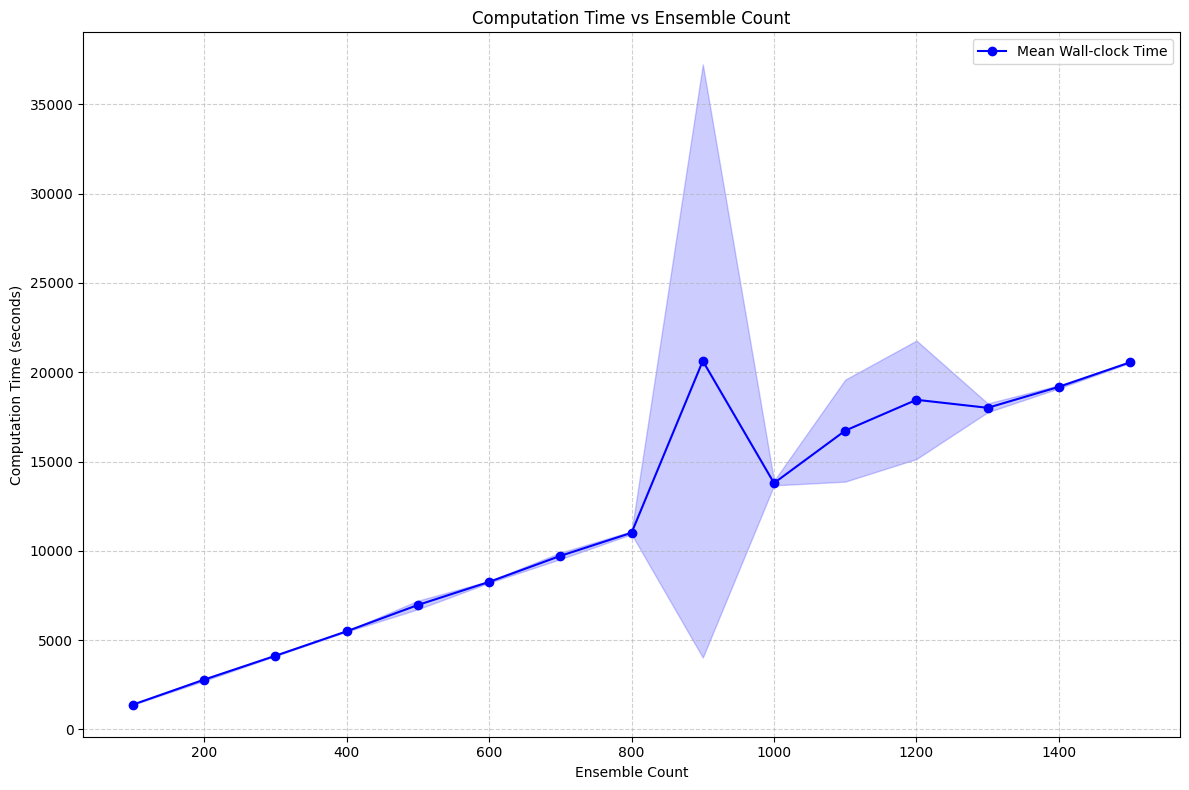

Plot saved to: final_plots\wallclock_vs_iterations.png


In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

PARENT_FOLDER = "results/EC_times"
OUTPUT_FOLDER = "final_plots"
NUM_RUNS = 5
NUM_EXPERIMENTS = 15
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

def find_file(run_dir, x):
    for fname in os.listdir(run_dir):
        if fname.endswith(f"_{x}.out"):
            return os.path.join(run_dir, fname)
    return None

def parse_out_file(path):
    num_iterations = None
    wallclock_sec = None
    with open(path, 'r') as f:
        for line in f:
            if "num_iterations" in line:
                m = re.search(r"num_iterations\s*=\s*(\d+)", line)
                if m:
                    num_iterations = int(m.group(1))
            elif "Job Wall-clock time" in line:
                m = re.search(r"Job Wall-clock time:\s*(\d+):(\d+):(\d+)", line)
                if m:
                    h, m_, s = map(int, m.groups())
                    wallclock_sec = h*3600 + m_*60 + s
    return num_iterations, wallclock_sec

# Collect data
walltimes_by_exp = {}
iterations_by_exp = {}

for y in range(1, NUM_RUNS+1):
    run_dir = os.path.join(PARENT_FOLDER, str(y))
    for x in range(1, NUM_EXPERIMENTS+1):
        file_path = find_file(run_dir, x)
        if file_path is None:
            continue
        num_iter, wall_sec = parse_out_file(file_path)
        if num_iter is None or wall_sec is None:
            continue
        walltimes_by_exp.setdefault(x, []).append(wall_sec)
        iterations_by_exp[x] = num_iter

# Compute mean and std
exp_ids = sorted(walltimes_by_exp.keys())
mean_walltimes = [np.mean(walltimes_by_exp[x]) for x in exp_ids]
std_walltimes = [np.std(walltimes_by_exp[x]) for x in exp_ids]
iterations = [iterations_by_exp[x] for x in exp_ids]


# target_iter = 900
# for exp_id, num_iter in iterations_by_exp.items():
#     if num_iter == target_iter:
#         print(f"\n=== Debug: Experiment {exp_id} with {target_iter} iterations ===")
#         vals = walltimes_by_exp.get(exp_id, [])
#         print("Walltimes (seconds):", vals)
#         if vals:
#             print(f"Mean = {np.mean(vals):.2f}, Std = {np.std(vals):.2f}")
#         print("=============================================\n")


# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(iterations, mean_walltimes, marker='o', color='blue', label='Mean Wall-clock Time')
ax.fill_between(iterations,
                np.array(mean_walltimes)-np.array(std_walltimes),
                np.array(mean_walltimes)+np.array(std_walltimes),
                color='blue', alpha=0.2)

ax.set_xlabel("Ensemble Count")
ax.set_ylabel("Computation Time (seconds)")
ax.set_title("Computation Time vs Ensemble Count")
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend()

out_path = os.path.join(OUTPUT_FOLDER, "wallclock_vs_iterations.png")
plt.tight_layout()
plt.savefig(out_path)
plt.show()
print(f"Plot saved to: {out_path}")


In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# === Config ===
PARENT_FOLDER = 'evaluations/ws_s5'  # root folder containing numbered subfolders: 1/, 2/, ...
OUTPUT_FOLDER = 'plots'
START_WS = 5   # window size for index 1
STEP_WS = 5     # increment per index step

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

def extract_metrics(file_path):
    """Extract Precision and Recall from a results .txt file."""
    precision, recall = None, None
    with open(file_path, 'r') as f:
        for line in f:
            if "Precision" in line:
                precision = float(line.strip().split(":")[-1].replace('%', '').strip())
            elif "Recall" in line:
                recall = float(line.strip().split(":")[-1].replace('%', '').strip())
    return precision, recall

def extract_index(filename):
    """
    Extract the LAST integer before .txt to serve as the per-run index (1,2,3,...).
    Works for names like results_1.txt, out1.txt, foo_bar_12.txt, etc.
    """
    m = re.search(r'(\d+)(?=\.txt$)', filename)
    return int(m.group(1)) if m else None

def get_stride_from_folder(folder):
    """Extract stride from folder name, e.g. 'ws_s10' -> 10. Returns None if not found."""
    m = re.search(r's(\d+)', os.path.basename(folder))
    return int(m.group(1)) if m else None

def plot_metrics():
    stride = get_stride_from_folder(PARENT_FOLDER)

    # Collect numbered subfolders (1/, 2/, ...)
    run_folders = [
        os.path.join(PARENT_FOLDER, d)
        for d in os.listdir(PARENT_FOLDER)
        if os.path.isdir(os.path.join(PARENT_FOLDER, d)) and d.isdigit()
    ]
    run_folders.sort(key=lambda p: int(os.path.basename(p)))  # sort by run number

    # Aggregate by per-run file index (1,2,3,...) so y-values stay identical;
    # we will only relabel the x-axis later to window sizes.
    precisions_by_idx = {}
    recalls_by_idx = {}

    for run_folder in run_folders:
        # Collect .txt files, keep only those with a numeric index, sort by that index
        files = [f for f in os.listdir(run_folder) if f.endswith('.txt')]
        files_with_idx = [(f, extract_index(f)) for f in files]
        files_with_idx = [(f, idx) for f, idx in files_with_idx if idx is not None]
        files_with_idx.sort(key=lambda t: t[1])  # sort by index

        for filename, idx in files_with_idx:
            file_path = os.path.join(run_folder, filename)
            precision, recall = extract_metrics(file_path)
            if precision is None or recall is None:
                continue
            precisions_by_idx.setdefault(idx, []).append(precision)
            recalls_by_idx.setdefault(idx, []).append(recall)

    # Align indices that appear in either metric (use intersection to ensure both exist)
    common_indices = sorted(set(precisions_by_idx.keys()) & set(recalls_by_idx.keys()))
    if not common_indices:
        print("No common indices found across runs with both Precision and Recall.")
        return

    # Compute means & stds per index
    mean_precisions = [np.mean(precisions_by_idx[i]) for i in common_indices]
    std_precisions  = [np.std(precisions_by_idx[i])  for i in common_indices]

    mean_recalls = [np.mean(recalls_by_idx[i]) for i in common_indices]
    std_recalls  = [np.std(recalls_by_idx[i])  for i in common_indices]

    # Map index -> window size (labels only; data unchanged)
    window_sizes = [START_WS + (i - 1) * STEP_WS for i in common_indices]

    # Optional: print a small mapping check
    print("Index -> WindowSize mapping:")
    for i, ws in zip(common_indices, window_sizes):
        n_runs_p = len(precisions_by_idx[i])
        n_runs_r = len(recalls_by_idx[i])
        print(f"  idx {i:>2} -> ws {ws:>3}   (P samples: {n_runs_p}, R samples: {n_runs_r})")

    # Plot with error bands (mean ± std)
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(window_sizes, mean_precisions, label='Precision (mean)', marker='o')
    ax.fill_between(window_sizes,
                    np.array(mean_precisions) - np.array(std_precisions),
                    np.array(mean_precisions) + np.array(std_precisions),
                    alpha=0.2)

    ax.plot(window_sizes, mean_recalls, label='Recall (mean)', marker='o')
    ax.fill_between(window_sizes,
                    np.array(mean_recalls) - np.array(std_recalls),
                    np.array(mean_recalls) + np.array(std_recalls),
                    alpha=0.2)

    title = "Precision and Recall vs Window Size"
    if stride is not None:
        title += f" (Stride {stride})"
    ax.set_title(title)
    ax.set_xlabel("Window Size")
    ax.set_ylabel("Percentage (%)")
    ax.set_xticks(window_sizes)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend()

    out_path = os.path.join(OUTPUT_FOLDER, f'precision_recall_ws_s{stride or "x"}.png')
    plt.tight_layout()
    plt.savefig(out_path)
    print(f"Plot saved to: {out_path}")
    plt.show()
    plt.close(fig)

# Run
plot_metrics()



Index -> EnsembleCount mapping:
  idx  1 -> ensembles  100   (P samples: 5, R samples: 5)
  idx  2 -> ensembles  200   (P samples: 5, R samples: 5)
  idx  3 -> ensembles  300   (P samples: 5, R samples: 5)
  idx  4 -> ensembles  400   (P samples: 5, R samples: 5)
  idx  5 -> ensembles  500   (P samples: 5, R samples: 5)
  idx  6 -> ensembles  600   (P samples: 5, R samples: 5)
  idx  7 -> ensembles  700   (P samples: 5, R samples: 5)
  idx  8 -> ensembles  800   (P samples: 5, R samples: 5)
  idx  9 -> ensembles  900   (P samples: 5, R samples: 5)
  idx 10 -> ensembles 1000   (P samples: 5, R samples: 5)
  idx 11 -> ensembles 1100   (P samples: 5, R samples: 5)
  idx 12 -> ensembles 1200   (P samples: 5, R samples: 5)
  idx 13 -> ensembles 1300   (P samples: 5, R samples: 5)
  idx 14 -> ensembles 1400   (P samples: 5, R samples: 5)
  idx 15 -> ensembles 1500   (P samples: 5, R samples: 5)
Plot saved to: plots\precision_recall_ensemble.png


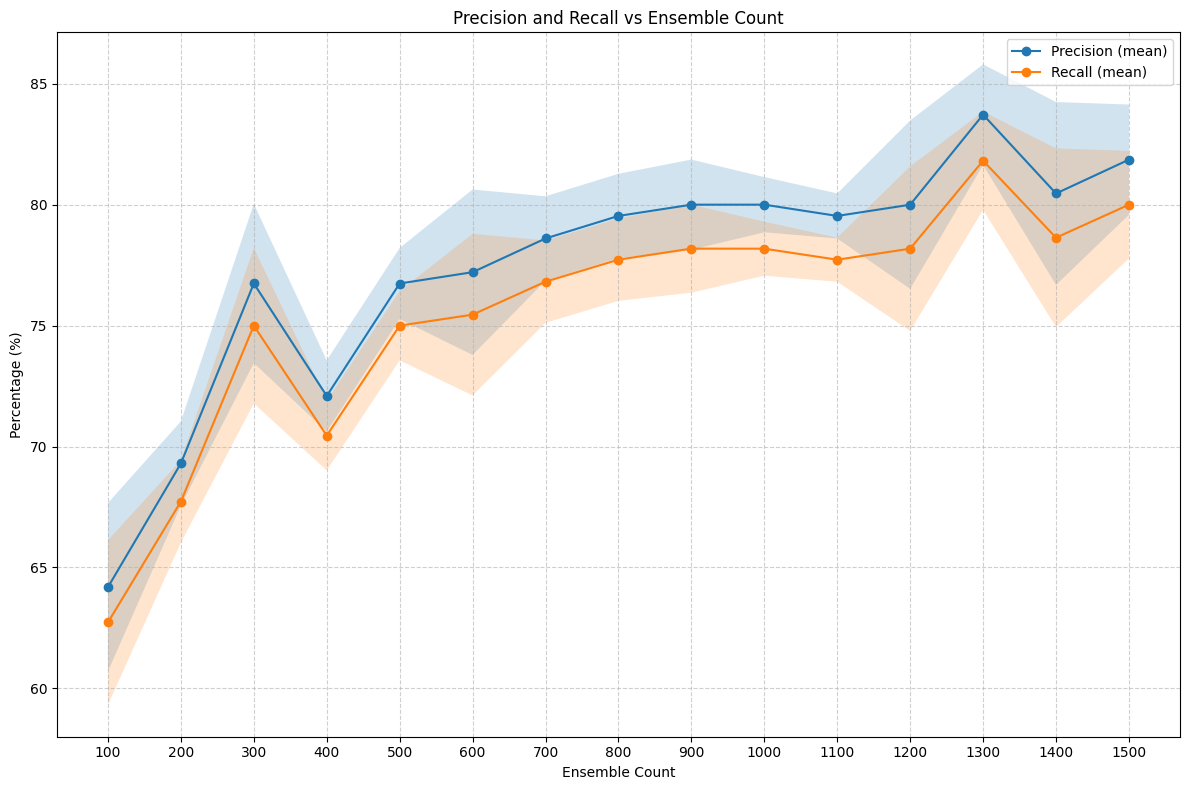

In [40]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# === Config ===
PARENT_FOLDER = 'evaluations/EC'  # root folder containing numbered subfolders: 1/, 2/, ...
OUTPUT_FOLDER = 'plots'
START_EC = 100   # ensemble count for index 1
STEP_EC = 100    # increment per index step

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

def extract_metrics(file_path):
    """Extract Precision and Recall from a results .txt file."""
    precision, recall = None, None
    with open(file_path, 'r') as f:
        for line in f:
            if "Precision" in line:
                precision = float(line.strip().split(":")[-1].replace('%', '').strip())
            elif "Recall" in line:
                recall = float(line.strip().split(":")[-1].replace('%', '').strip())
    return precision, recall

def extract_index(filename):
    """
    Extract the LAST integer before .txt to serve as the per-run index (1,2,3,...).
    Works for names like results_1.txt, out1.txt, foo_bar_12.txt, etc.
    """
    m = re.search(r'(\d+)(?=\.txt$)', filename)
    return int(m.group(1)) if m else None

def plot_metrics():
    # Collect numbered subfolders (1/, 2/, ...)
    run_folders = [
        os.path.join(PARENT_FOLDER, d)
        for d in os.listdir(PARENT_FOLDER)
        if os.path.isdir(os.path.join(PARENT_FOLDER, d)) and d.isdigit()
    ]
    run_folders.sort(key=lambda p: int(os.path.basename(p)))  # sort by run number

    # Aggregate by per-run file index (1,2,3,...) so y-values stay identical;
    # we will only relabel the x-axis later to ensemble counts.
    precisions_by_idx = {}
    recalls_by_idx = {}

    for run_folder in run_folders:
        # Collect .txt files, keep only those with a numeric index, sort by that index
        files = [f for f in os.listdir(run_folder) if f.endswith('.txt')]
        files_with_idx = [(f, extract_index(f)) for f in files]
        files_with_idx = [(f, idx) for f, idx in files_with_idx if idx is not None]
        files_with_idx.sort(key=lambda t: t[1])  # sort by index

        for filename, idx in files_with_idx:
            file_path = os.path.join(run_folder, filename)
            precision, recall = extract_metrics(file_path)
            if precision is None or recall is None:
                continue
            precisions_by_idx.setdefault(idx, []).append(precision)
            recalls_by_idx.setdefault(idx, []).append(recall)

    # Align indices that appear in both Precision and Recall
    common_indices = sorted(set(precisions_by_idx.keys()) & set(recalls_by_idx.keys()))
    if not common_indices:
        print("No common indices found across runs with both Precision and Recall.")
        return

    # Compute means & stds per index
    mean_precisions = [np.mean(precisions_by_idx[i]) for i in common_indices]
    std_precisions  = [np.std(precisions_by_idx[i])  for i in common_indices]

    mean_recalls = [np.mean(recalls_by_idx[i]) for i in common_indices]
    std_recalls  = [np.std(recalls_by_idx[i])  for i in common_indices]

    # Map index -> ensemble count (100, 200, ..., 1500)
    ensemble_counts = [START_EC + (i - 1) * STEP_EC for i in common_indices]

    # Optional: print mapping
    print("Index -> EnsembleCount mapping:")
    for i, ec in zip(common_indices, ensemble_counts):
        n_runs_p = len(precisions_by_idx[i])
        n_runs_r = len(recalls_by_idx[i])
        print(f"  idx {i:>2} -> ensembles {ec:>4}   (P samples: {n_runs_p}, R samples: {n_runs_r})")

    # Plot with error bands (mean ± std)
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(ensemble_counts, mean_precisions, label='Precision (mean)', marker='o')
    ax.fill_between(ensemble_counts,
                    np.array(mean_precisions) - np.array(std_precisions),
                    np.array(mean_precisions) + np.array(std_precisions),
                    alpha=0.2)

    ax.plot(ensemble_counts, mean_recalls, label='Recall (mean)', marker='o')
    ax.fill_between(ensemble_counts,
                    np.array(mean_recalls) - np.array(std_recalls),
                    np.array(mean_recalls) + np.array(std_recalls),
                    alpha=0.2)

    ax.set_title("Precision and Recall vs Ensemble Count")
    ax.set_xlabel("Ensemble Count")
    ax.set_ylabel("Percentage (%)")
    ax.set_xticks(ensemble_counts)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend()

    out_path = os.path.join(OUTPUT_FOLDER, f'precision_recall_ensemble.png')
    plt.tight_layout()
    plt.savefig(out_path)
    print(f"Plot saved to: {out_path}")
    plt.show()
    plt.close(fig)

# Run
plot_metrics()
